In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi import StockTradingEnv, INITIAL_ACCOUNT_BALANCE
import matplotlib.pyplot as plt


In [18]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        # x = torch.nn.functional.softmax(x, dim=-1)
        return x

In [19]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 2  # 0: Buy, 1: Sell 2: hold
        self.memory = deque(maxlen=200)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.999
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(0,self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            return action_type
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        print("q_values",q_values)
        action_type = torch.argmax(q_values[0]).item()
        print("action_type",action_type, "epsilon",self.epsilon)
        return action_type
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state).detach().clone()
            if done:
                target[0][action] = reward
            else:
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * torch.max(t).item()
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

In [20]:
def plot_buy_sell(env, trades):
    plt.figure(figsize=(15, 7))

    # Plot stock price with a thinner line
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

    # Extract buy and sell trades
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]

    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', s=40, label='Sell', alpha=1)
    
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', s=40, label='Buy', alpha=0.6)


    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()
    

In [21]:
def plot_networth(env, networths):
    """
    Plot the net worth of the trading bot over time and compare it with the net worth
    if the initial amount was fully invested in the stock.
    """
    dates = env.df['Date']
    stock_prices = env.df['Close']
    
    # Calculate the hypothetical net worth if the initial balance was fully invested in the stock
    initial_stock_price = stock_prices.iloc[0]
    shares_if_fully_invested = INITIAL_ACCOUNT_BALANCE / initial_stock_price
    hypothetical_networths = shares_if_fully_invested * stock_prices
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates, hypothetical_networths, label='Hypothetical Net Worth (Fully Invested in Stock)', linewidth=1, color='r')
    plt.plot(dates[:len(networths)], networths, label='Actual Net Worth', linewidth=1, color='b')
    
    plt.xlabel('Date')
    plt.ylabel('Net Worth')
    plt.title('DQN Trading Bot Net Worth Over Time')
    plt.legend()
    plt.show()

In [22]:
# df = pd.read_csv('./data/AAPL.csv')
# df = pd.read_csv('./data/^GSPC_2010-2015.csv')
df = pd.read_csv('./data/^GSPC_2018.csv')
# df = pd.read_csv('./data/FB_2018.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 10

action: 0 networth: 20000.0 balance: 17316.263340307793 shares_held: 1 current_price: 2683.736659692207
networth: 20000.0 reward: -0.04977916747884592
action: 0 networth: 20024.75490537636 balance: 14607.771775239222 shares_held: 2 current_price: 2708.4915650685703
networth: 20024.75490537636 reward: -134.97153096827242
action: 1 networth: 20052.21541872414 balance: 17329.99359698168 shares_held: 1 current_price: 2722.221821742459
networth: 20052.21541872414 reward: -47.401165001898335
action: 0 networth: 20062.720732131173 balance: 14597.266461832187 shares_held: 2 current_price: 2732.727135149493
networth: 20062.720732131173 reward: -57.278273226722376
action: 1 networth: 20092.57810216964 balance: 17344.922282000913 shares_held: 1 current_price: 2747.655820168727
networth: 20092.57810216964 reward: -51.538516625401826
action: 0 networth: 20096.140464847616 balance: 14593.704099154207 shares_held: 2 current_price: 2751.218182846705
networth: 20096.140464847616 reward: -19.42312189042

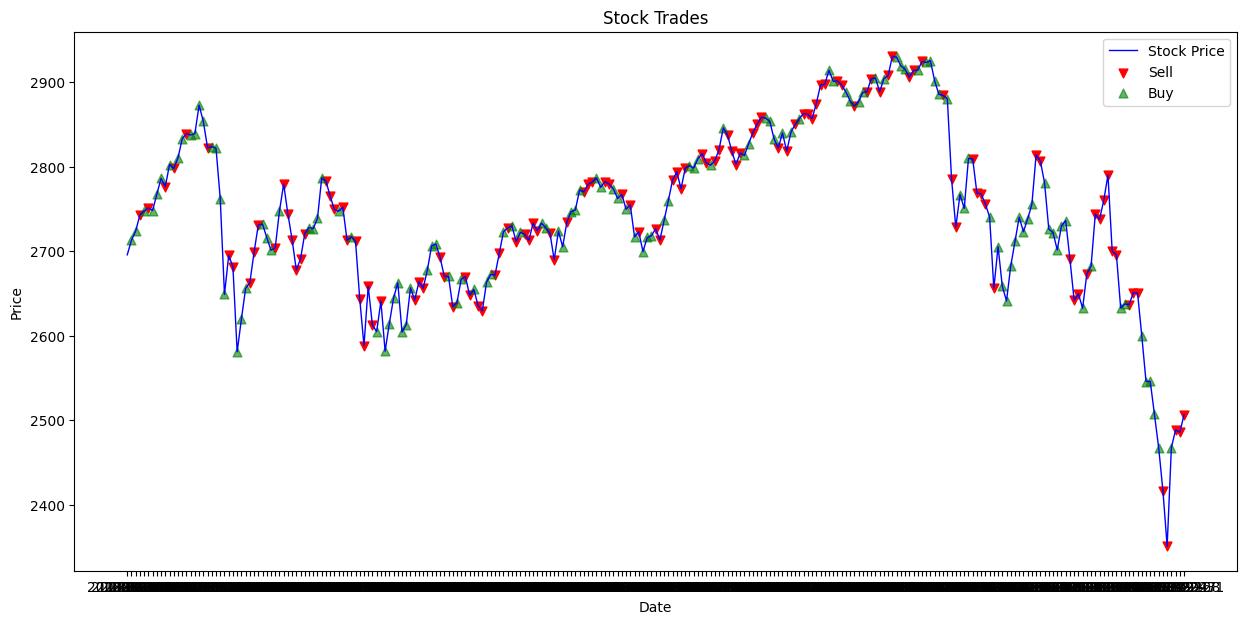

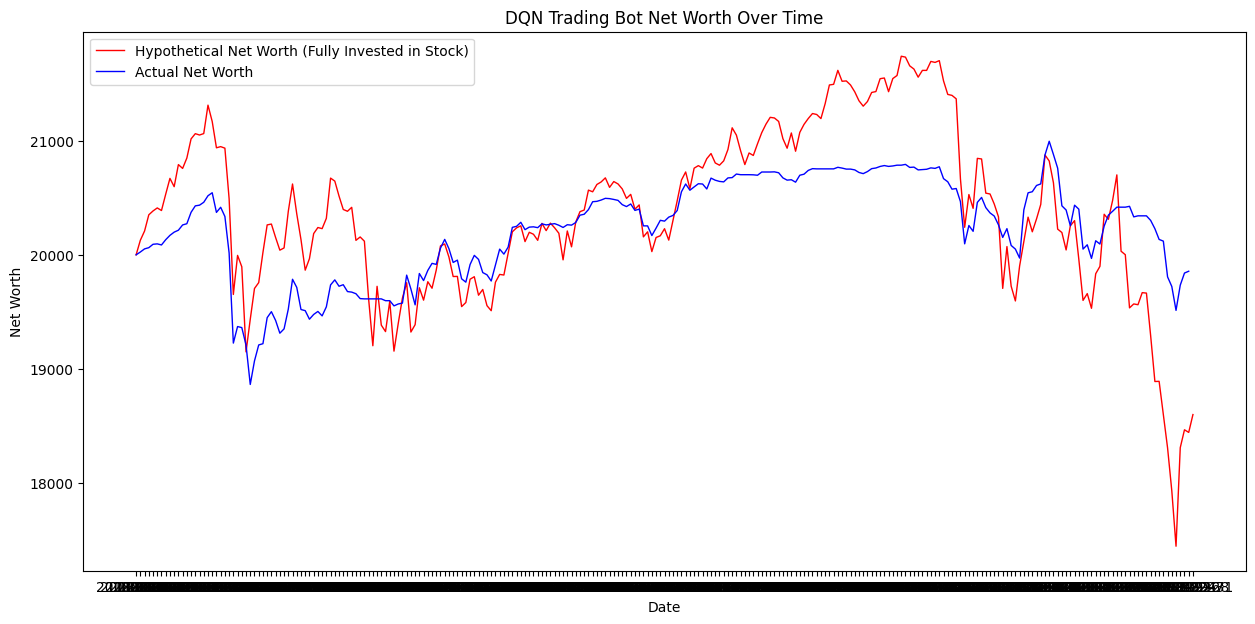

action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2685.843245867489
networth: 20000.0 reward: -15.748721989450132
action: 0 networth: 20000.0 balance: 17296.207210015782 shares_held: 1 current_price: 2703.792789984219
networth: 20000.0 reward: -133.76564893261093
action: 0 networth: 20018.210443227552 balance: 14574.20397680401 shares_held: 2 current_price: 2722.0032332117717
networth: 20018.210443227552 reward: -99.28906471929076
action: 0 networth: 20051.718813369676 balance: 11835.446558521176 shares_held: 3 current_price: 2738.7574182828334
networth: 20051.718813369676 reward: -57.84071703015434
action: 1 networth: 20067.13067324712 balance: 14579.341263429824 shares_held: 2 current_price: 2743.8947049086473
networth: 20067.13067324712 reward: -7.460956155868189
action: 0 networth: 20081.9073738943 balance: 11828.058208197586 shares_held: 3 current_price: 2751.283055232238
networth: 20081.9073738943 reward: -25.50690938257685
action: 0 networth: 20065.3369022

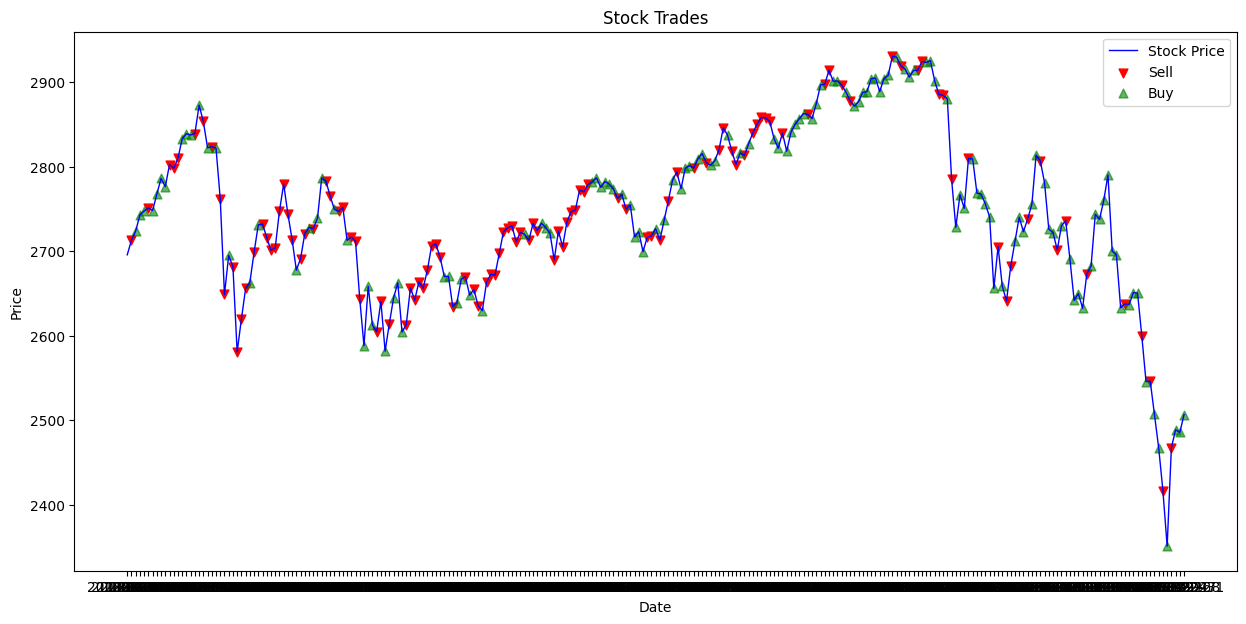

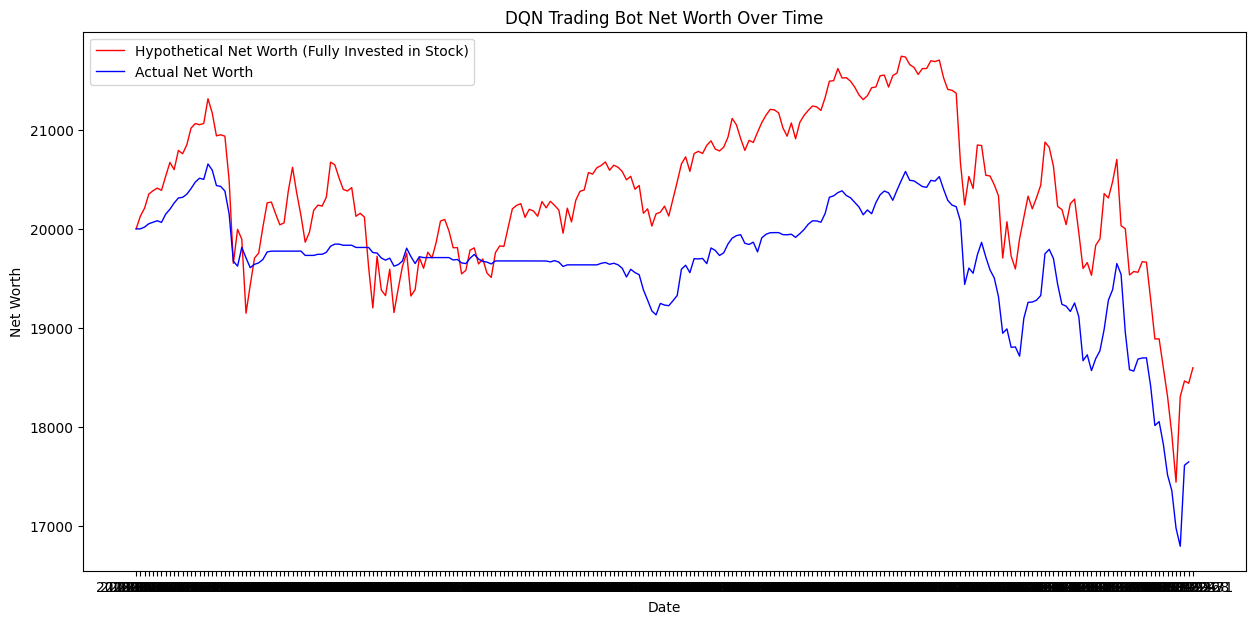

action: 0 networth: 20000.0 balance: 17304.697608179613 shares_held: 1 current_price: 2695.302391820386
networth: 20000.0 reward: -86.24125308154908
action: 0 networth: 20009.84879260895 balance: 14599.546423750275 shares_held: 2 current_price: 2705.151184429338
networth: 20009.84879260895 reward: -53.698715321632335
q_values tensor([[-63.5993,  -4.9215]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.6242304567266527
action: 1 networth: 20039.412787970527 balance: 17319.4796058604 shares_held: 1 current_price: 2719.933182110126
networth: 20039.412787970527 reward: -51.03210579138613
q_values tensor([[-40.0020,  -3.8204]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.623606226269926
action: 1 networth: 20056.109477139333 balance: 20056.109477139333 shares_held: 0 current_price: 2736.629871278932
networth: 20056.109477139333 reward: -91.03560142737842
q_values tensor([[-1.4819, -1.3055]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.6229826200436561
action: 1 networth: 200

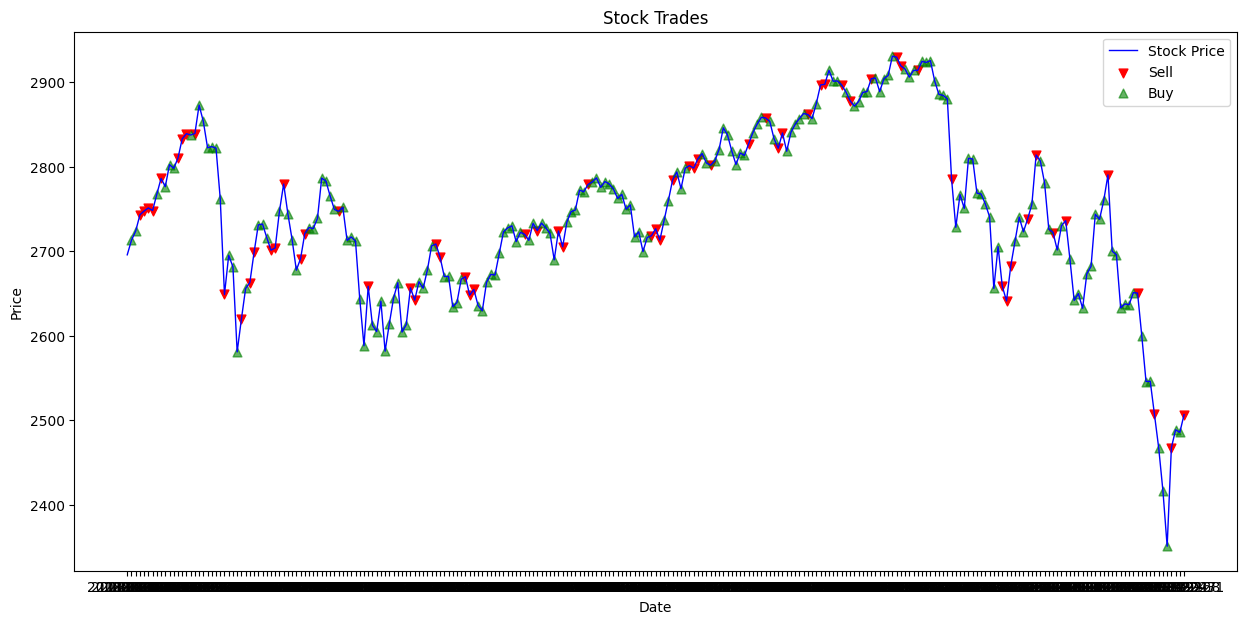

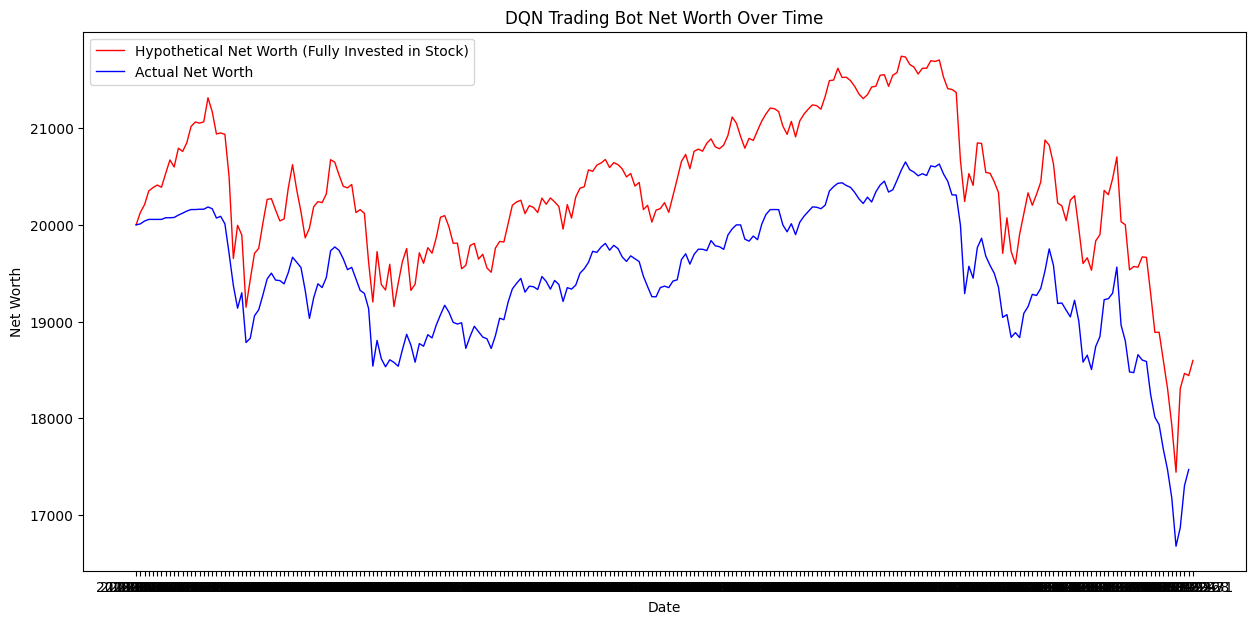

action: 0 networth: 20000.0 balance: 17311.854671470304 shares_held: 1 current_price: 2688.1453285296966
networth: 20000.0 reward: -32.90456612700291
q_values tensor([[-41.5630, -68.1229]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.4865769398194536
action: 0 networth: 20011.87081507849 balance: 14611.838527862117 shares_held: 2 current_price: 2700.016143608187
networth: 20011.87081507849 reward: -64.72341786912875
action: 1 networth: 20051.601052130176 balance: 17331.719789996147 shares_held: 1 current_price: 2719.8812621340294
networth: 20051.601052130176 reward: -68.58063788541767
q_values tensor([[-31.9305, -50.1956]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.48560427251675453
action: 0 networth: 20071.49401107909 balance: 14591.945568913206 shares_held: 2 current_price: 2739.7742210829406
networth: 20071.49401107909 reward: -108.46266968110285
action: 0 networth: 20080.008790465126 balance: 11847.913958137246 shares_held: 3 current_price: 2744.0316107759604
networt

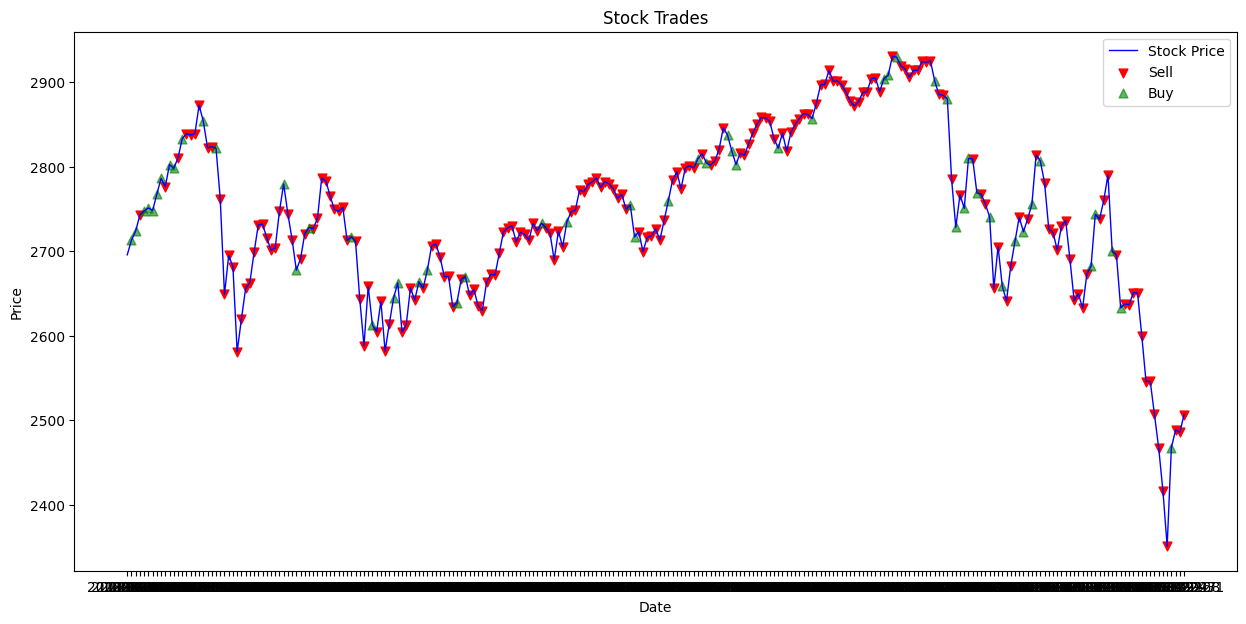

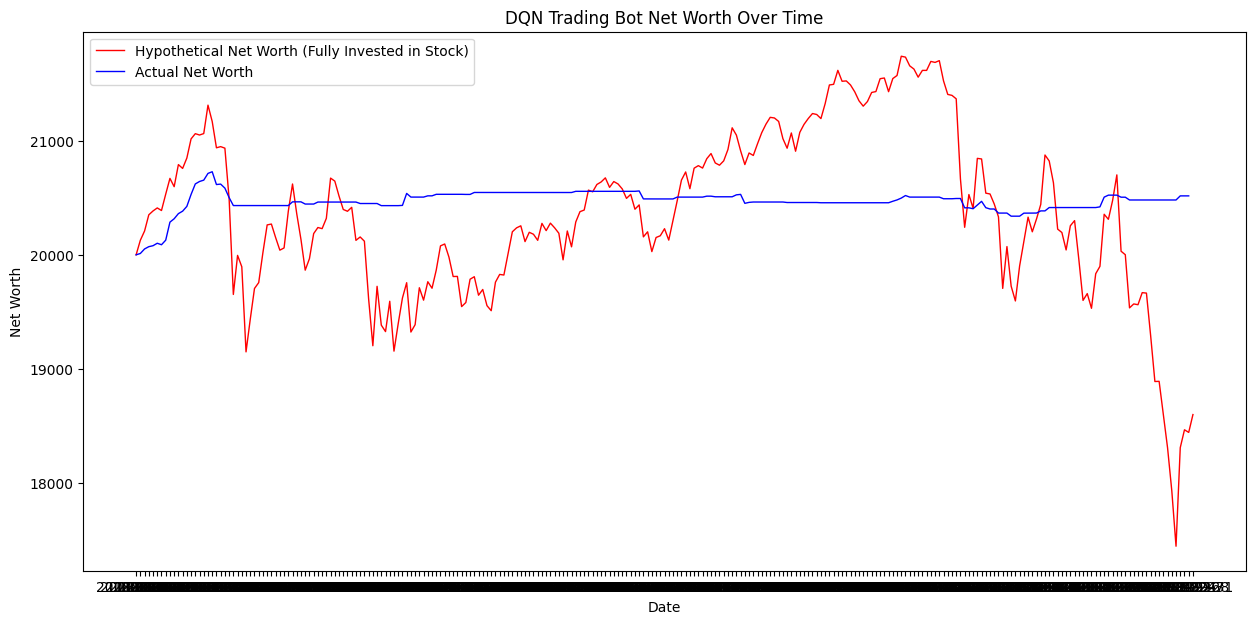

action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2695.540655988486
networth: 20000.0 reward: -88.01687261015468
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2701.6497477049934
networth: 20000.0 reward: -45.52687313578281
q_values tensor([[-100.1103,   11.5133]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.37852020570012296
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2722.4946610297193
networth: 20000.0 reward: -155.3428510324702
q_values tensor([[-77.8508,   6.6748]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.37814168549442284
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2741.0042767777654
networth: 20000.0 reward: -137.9394789042526
q_values tensor([[-29.7477,  15.7623]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.3777635438089284
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2743.2758353388353
networth: 20000.0 reward: -16.928368

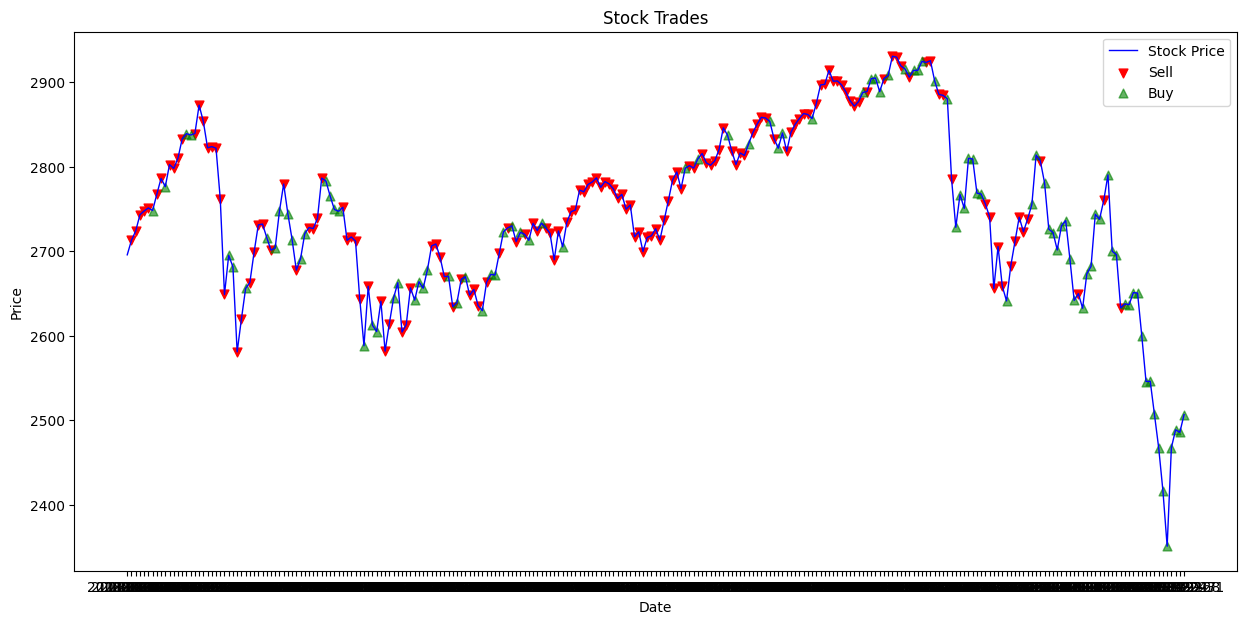

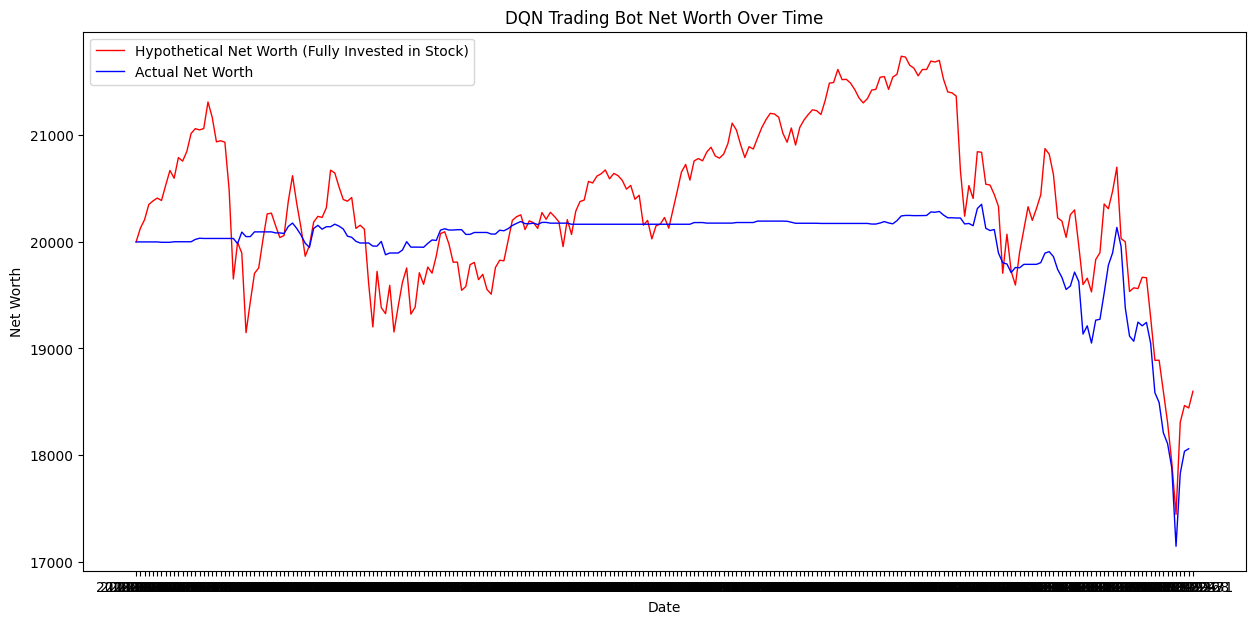

action: 0 networth: 20000.0 balance: 17315.25199117007 shares_held: 1 current_price: 2684.7480088299317
networth: 20000.0 reward: -7.58667106987923
q_values tensor([[-21.0541, -20.3366]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.2950500113615046
action: 1 networth: 20021.695069338493 balance: 20021.695069338493 shares_held: 0 current_price: 2706.4430781684227
networth: 20021.695069338493 reward: -118.28834239353455
q_values tensor([[-51.6187, -95.3287]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.2947549613501431
action: 0 networth: 20021.695069338493 balance: 17299.158018688635 shares_held: 1 current_price: 2722.5370506498584
networth: 20021.695069338493 reward: -119.93734542128368
q_values tensor([[-43.5518, -83.8417]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.294460206388793
action: 0 networth: 20035.094149756715 balance: 14563.221887620555 shares_held: 2 current_price: 2735.9361310680792
networth: 20035.094149756715 reward: -73.05600122959731
q_values tenso

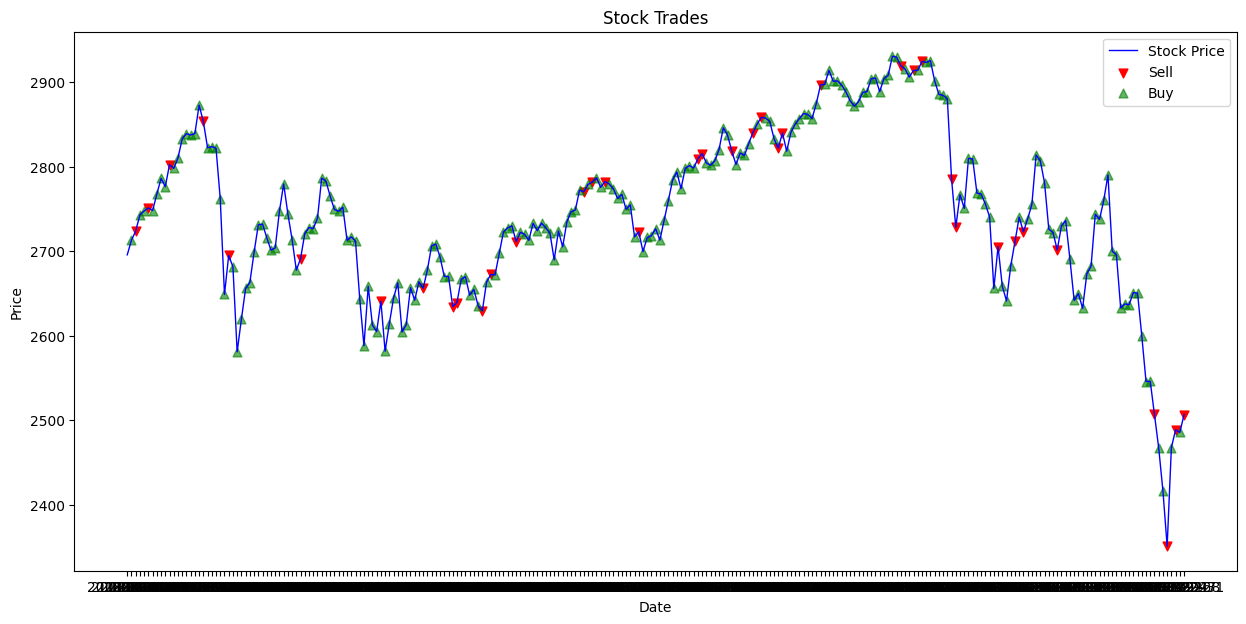

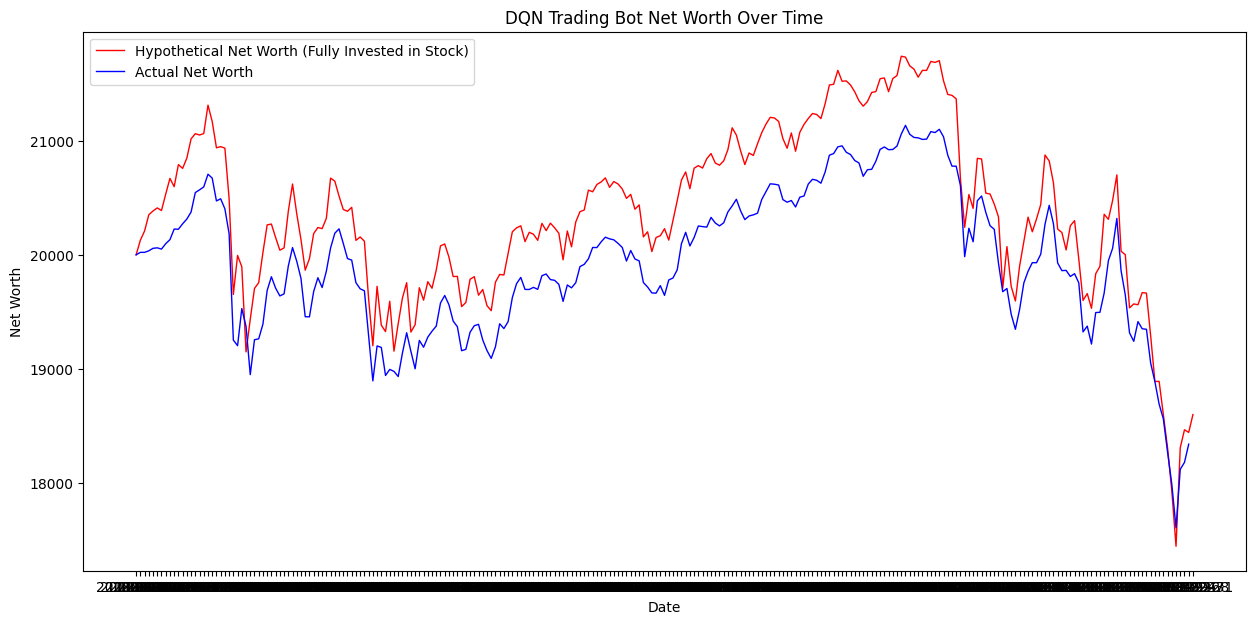

q_values tensor([[-13.5896, -57.4996]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.22998642580626621
action: 0 networth: 20000.0 balance: 17314.066414698496 shares_held: 1 current_price: 2685.9335853015027
networth: 20000.0 reward: -16.421959868726844
q_values tensor([[ -80.4043, -125.2647]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.22975643938045995
action: 0 networth: 20012.973914404738 balance: 14615.158914992255 shares_held: 2 current_price: 2698.907499706241
networth: 20012.973914404738 reward: -70.73786238467437
q_values tensor([[-138.5743, -214.6079]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.2295266829410795
action: 0 networth: 20057.751609877974 balance: 11893.862567549395 shares_held: 3 current_price: 2721.29634744286
networth: 20057.751609877974 reward: -77.29334498052413
q_values tensor([[ -95.5009, -151.8826]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.22929715625813843
action: 0 networth: 20093.006110030234 balance: 9160.814720055783 share

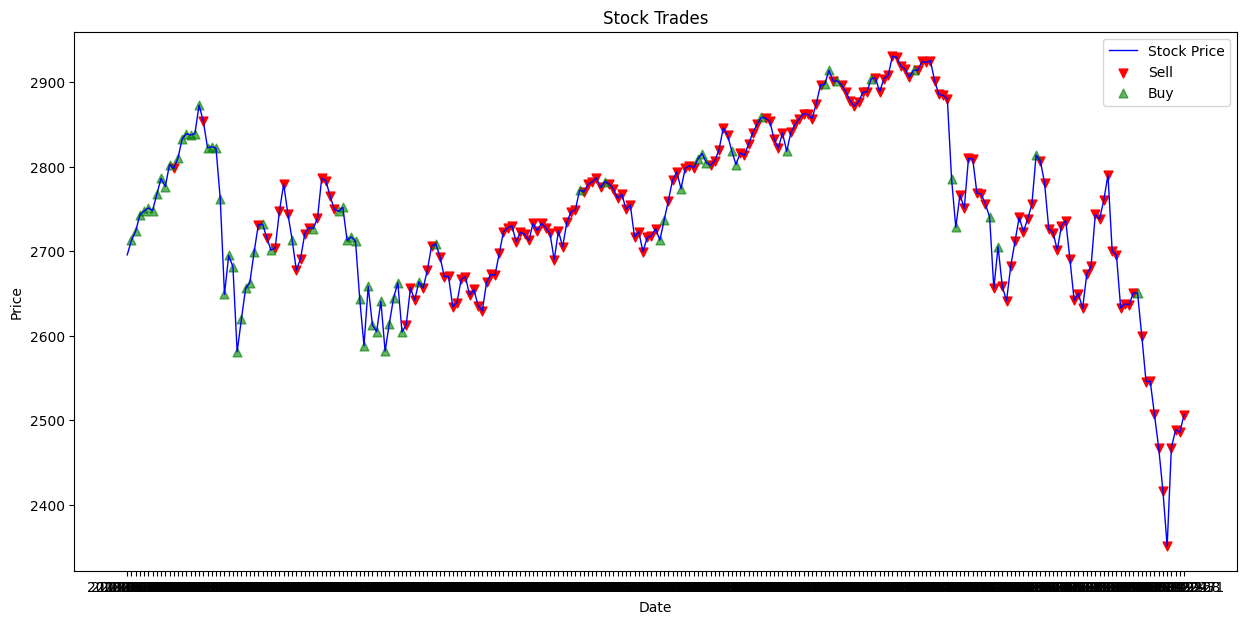

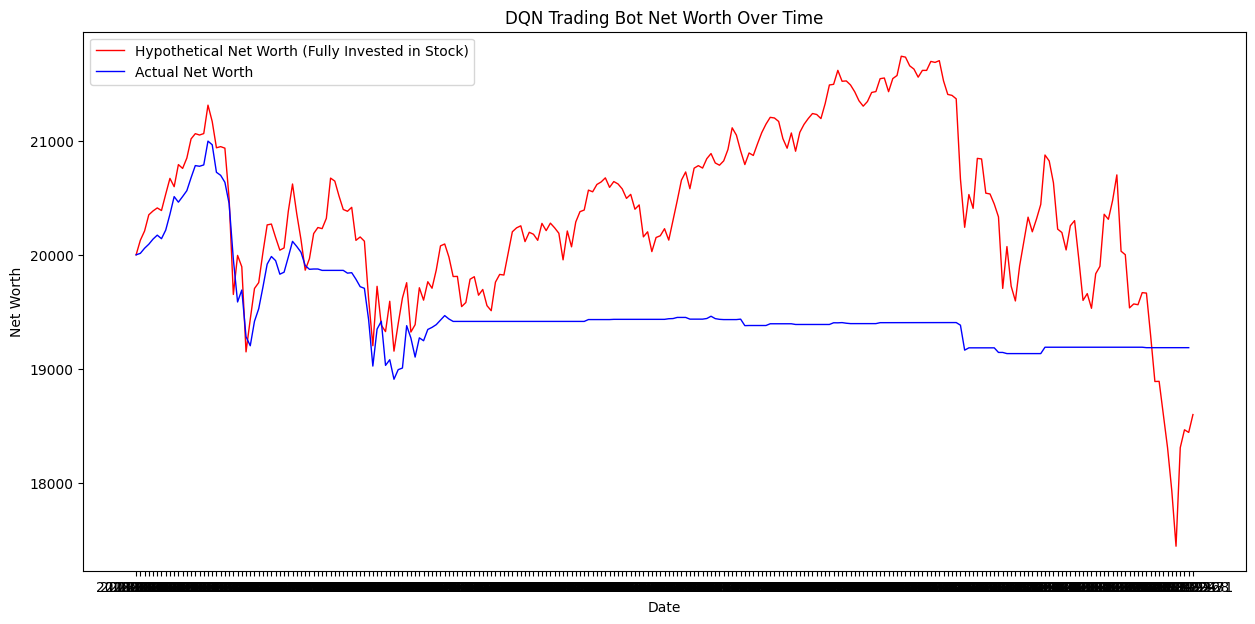

q_values tensor([[ -29.9571, -100.1510]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.17909120577644616
action: 0 networth: 20000.0 balance: 17308.94365062222 shares_held: 1 current_price: 2691.05634937778
networth: 20000.0 reward: -54.59840917214751
q_values tensor([[-87.5402, -83.7335]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.17891211457066972
action: 1 networth: 20020.317074513972 balance: 20020.317074513972 shares_held: 0 current_price: 2711.373423891752
networth: 20020.317074513972 reward: -110.77508115080855
q_values tensor([[-82.8595, -99.3319]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.17873320245609906
action: 0 networth: 20020.317074513972 balance: 17300.02043500923 shares_held: 1 current_price: 2720.2966395047406
networth: 20020.317074513972 reward: -66.4986096178618
q_values tensor([[-57.2796, -66.3450]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.17855446925364296
action: 0 networth: 20039.889289972638 balance: 14560.151580045827 shares_hel

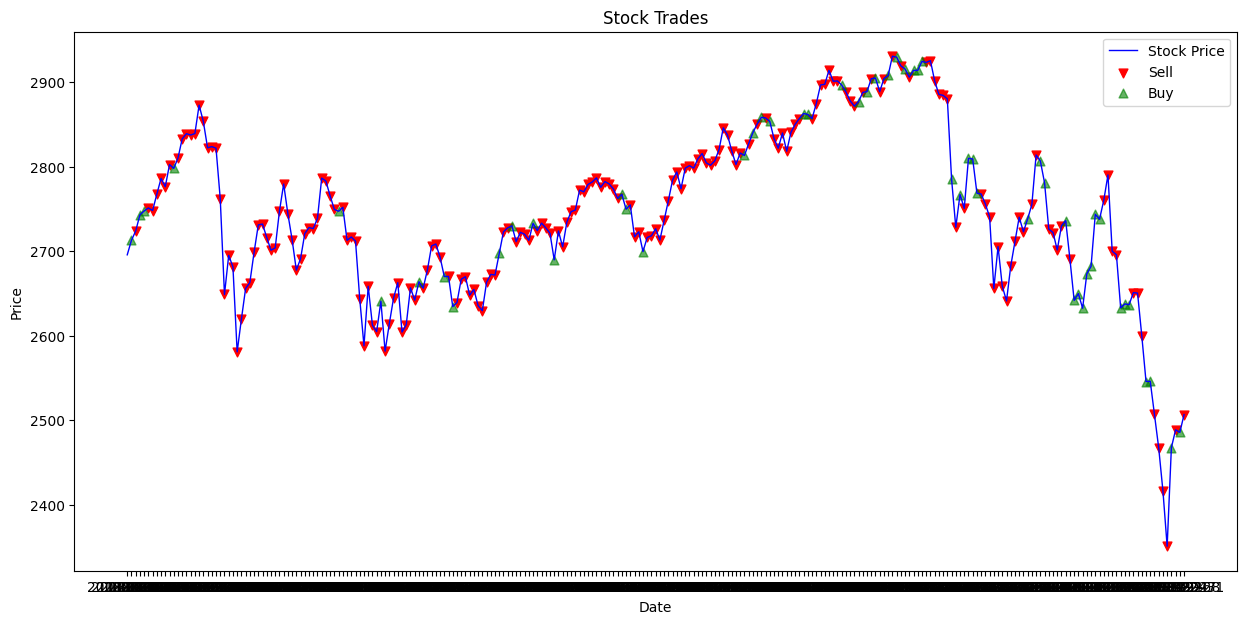

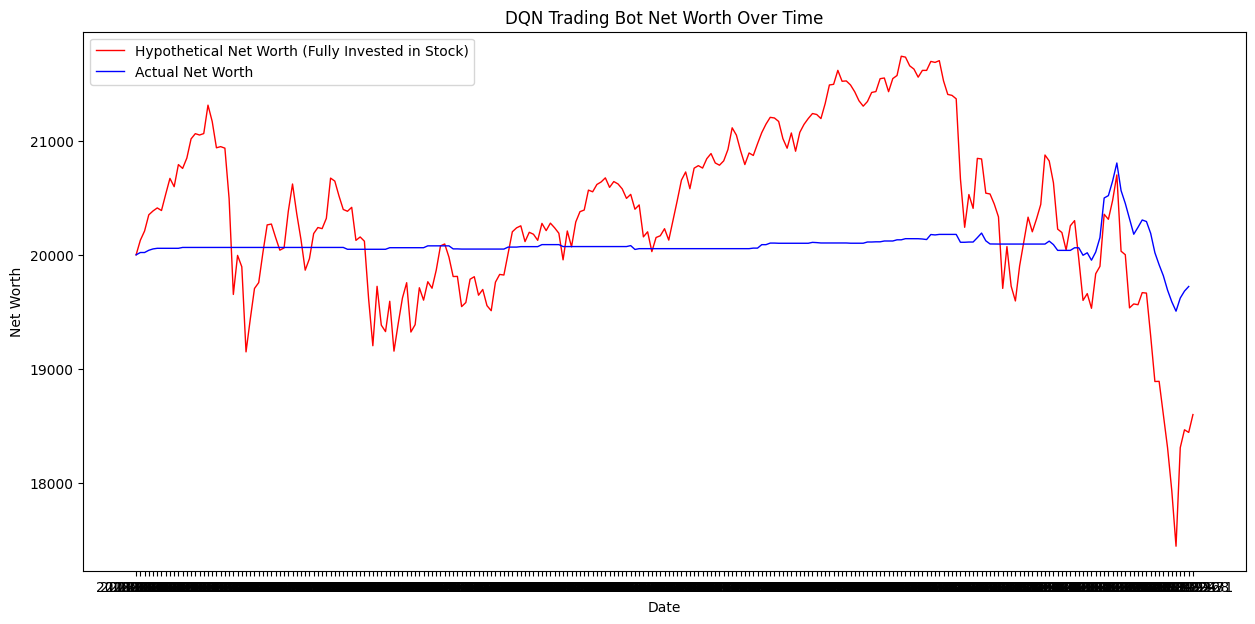

action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2691.5671372350407
networth: 20000.0 reward: -58.40496095691924
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2703.3476711508033
networth: 20000.0 reward: -87.79224440278631
action: 0 networth: 20000.0 balance: 17280.619703802484 shares_held: 1 current_price: 2719.380296197515
networth: 20000.0 reward: -119.48016504038605
q_values tensor([[-56.0753, -79.0247]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.13904096767148003
action: 0 networth: 20018.58988807537 balance: 14542.649519529597 shares_held: 2 current_price: 2737.970184272887
networth: 20018.58988807537 reward: -101.3579173870603
q_values tensor([[-6.6620, -2.3918]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.13890192670380855
action: 1 networth: 20029.328276216725 balance: 17285.98889787316 shares_held: 1 current_price: 2743.3393783435627
networth: 20029.328276216725 reward: -18.53614685552384
q_values tensor([[ 13.

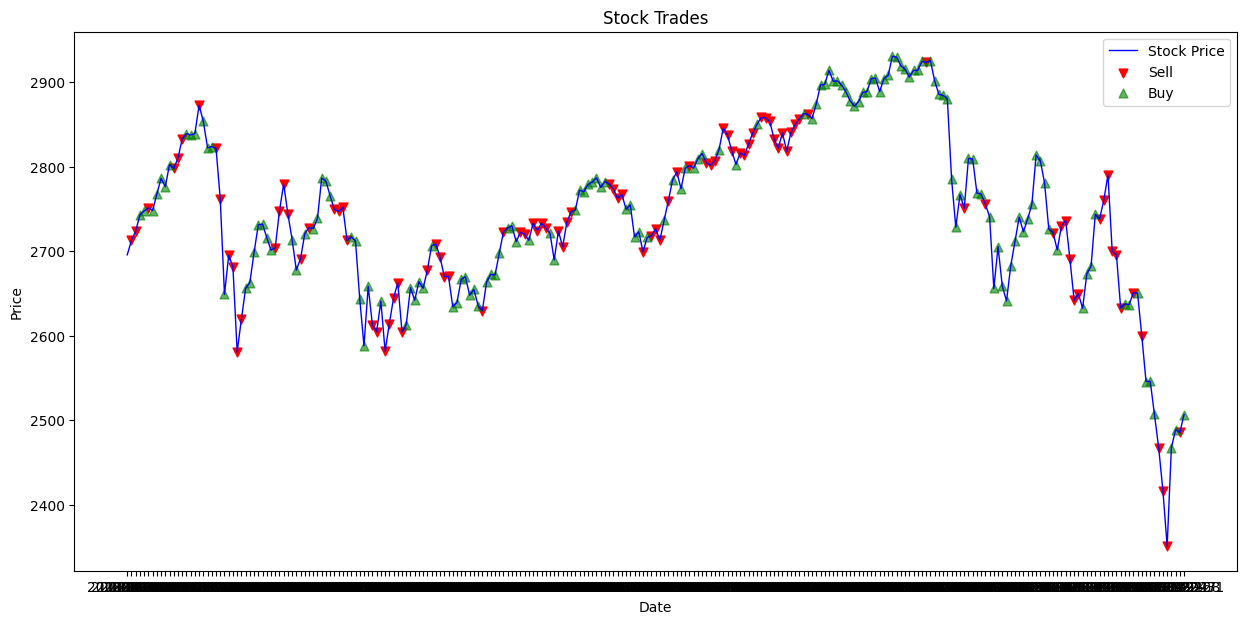

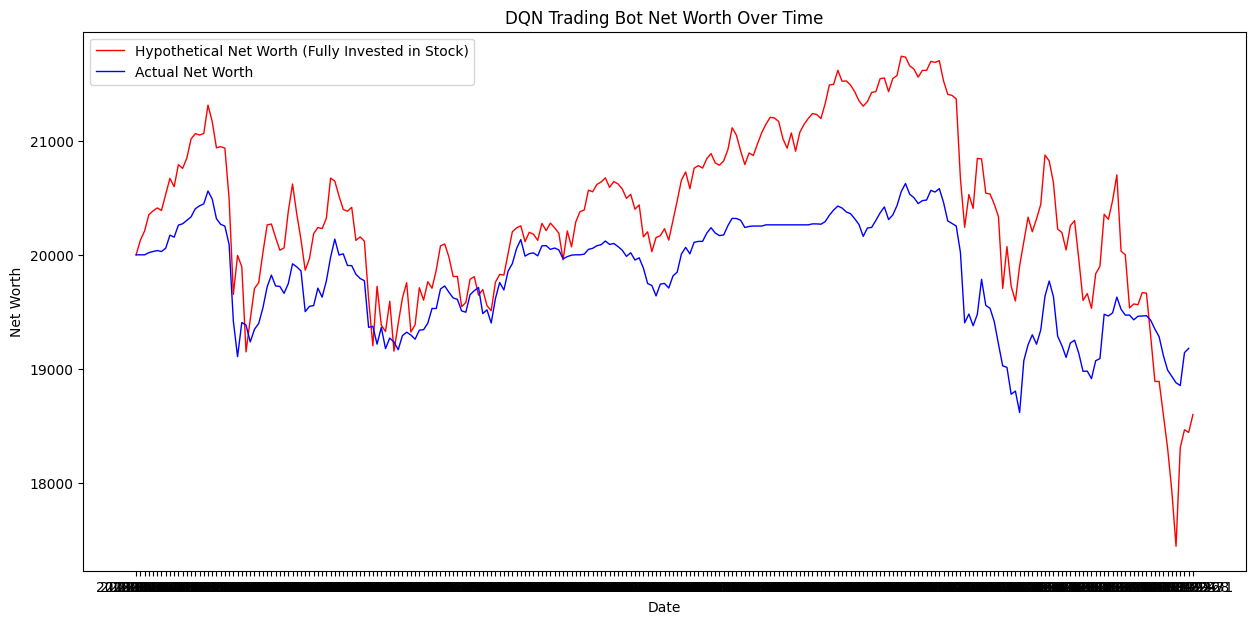

q_values tensor([[-55.0853, -43.8941]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.10859713639263872
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2688.456857556678
networth: 20000.0 reward: -35.22617843005355
q_values tensor([[-134.4149, -115.7725]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.10848853925624609
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2703.8402761780562
networth: 20000.0 reward: -114.64207454565258
q_values tensor([[-154.7177, -140.2430]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.10838005071698985
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2721.176070396678
networth: 20000.0 reward: -129.19179163189256
q_values tensor([[-147.5788, -140.0415]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.10827167066627286
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2732.7834911965865
networth: 20000.0 reward: -86.50215100931382
q_values tenso

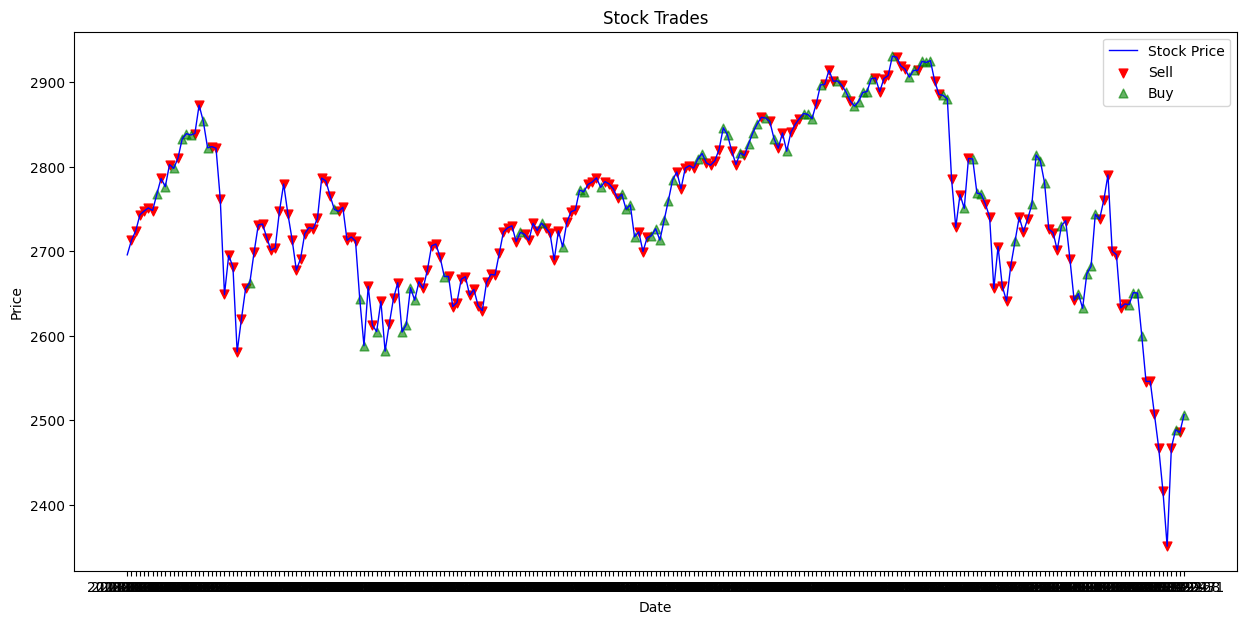

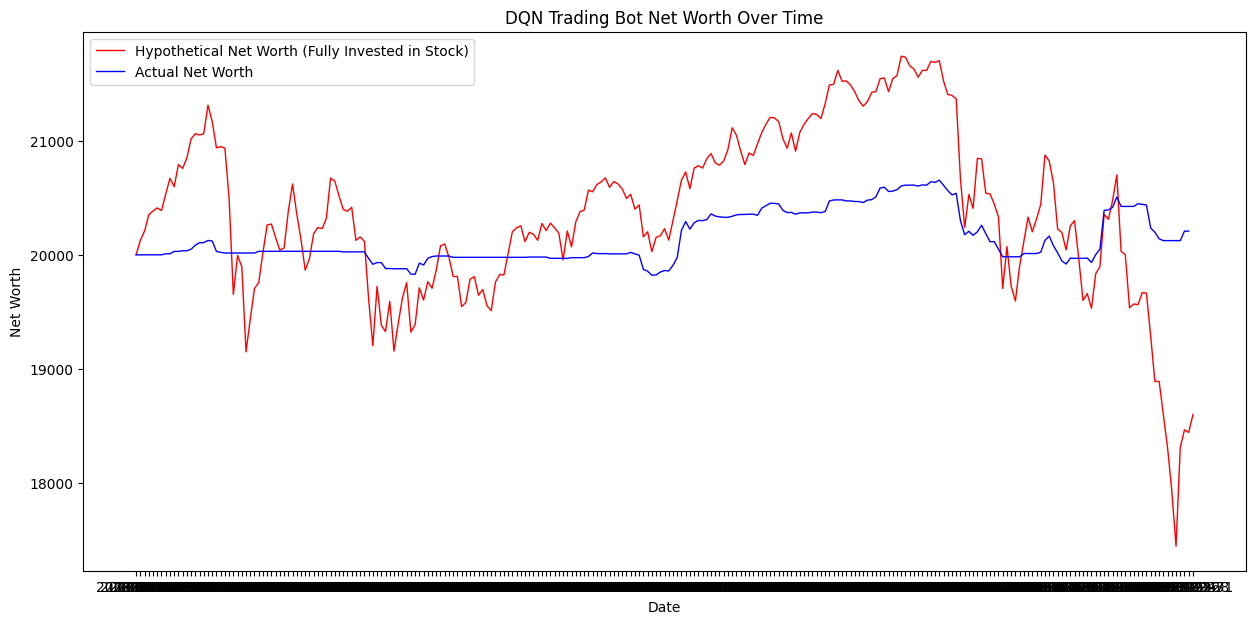

In [23]:
networths = []
for e in range(episodes):
    state = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    trades = []
    networth = []
    for time in range(1,len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done= env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        trades.append((env.current_step, action))  # Log the trade action
        if done:
            agent.update_target_model()
            break
        agent.replay()
        networth.append(env.net_worth)
    print(f'Episode {e+1}/{episodes} - NetWorth: {env.net_worth}')
    networths.append(env.net_worth)
    plot_buy_sell(env,trades)
    plot_networth(env,networth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_dqn_{e+1}")
    agent.save("model_dqn_temp")

[19856.050051864848, 17647.820425513477, 17470.44813126595, 20517.35680645838, 18058.91953069072, 18338.34162908434, 19185.135411682943, 19722.119419970284, 19179.490769914893, 20208.072025551963]


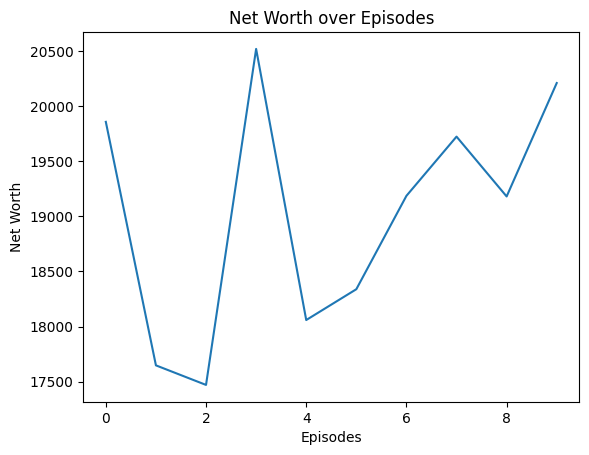

In [24]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

q_values tensor([[-142.1324,  -54.0228]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 1.0
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2688.204935419482
networth: 20000.0 reward: -33.34877541951573
q_values tensor([[-300.0242, -123.6652]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 1.0
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2699.896971342802
networth: 20000.0 reward: -87.13272952534317
q_values tensor([[-304.2216, -142.3087]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 1.0
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2720.286704045343
networth: 20000.0 reward: -151.95070185519216
q_values tensor([[-241.4207, -122.0356]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 1.0
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 2731.8297540673443
networth: 20000.0 reward: -86.02243972399447
q_values tensor([[-101.5170,  -49.0577]], grad_fn=<AddmmBackward0>)
action_typ

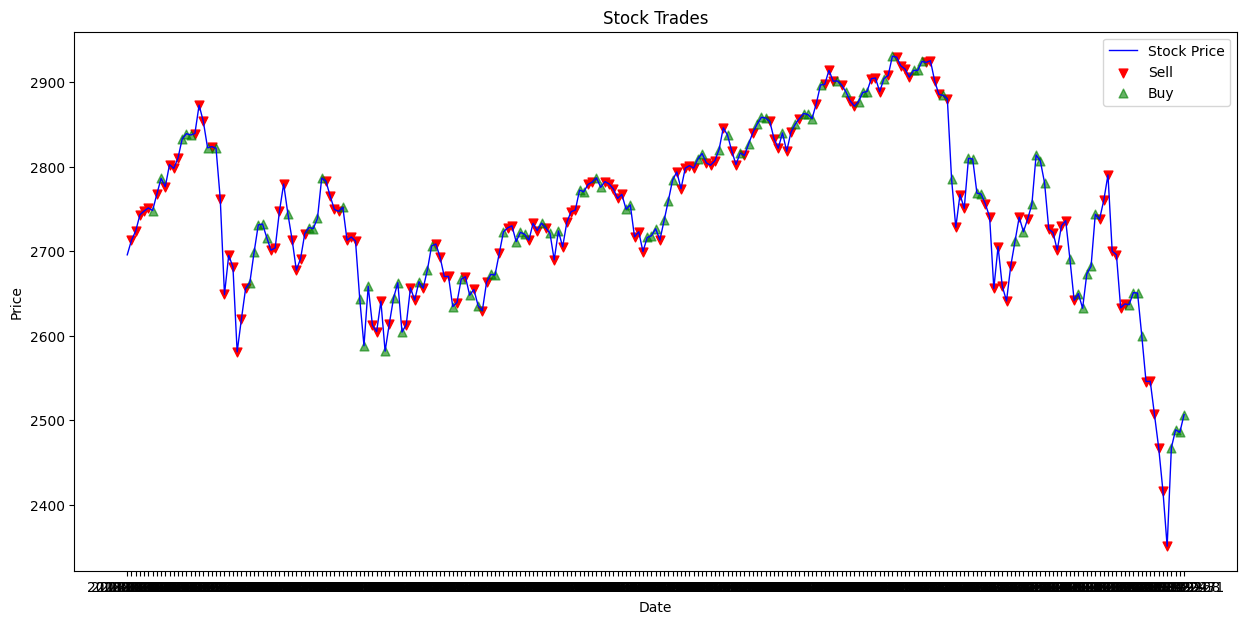

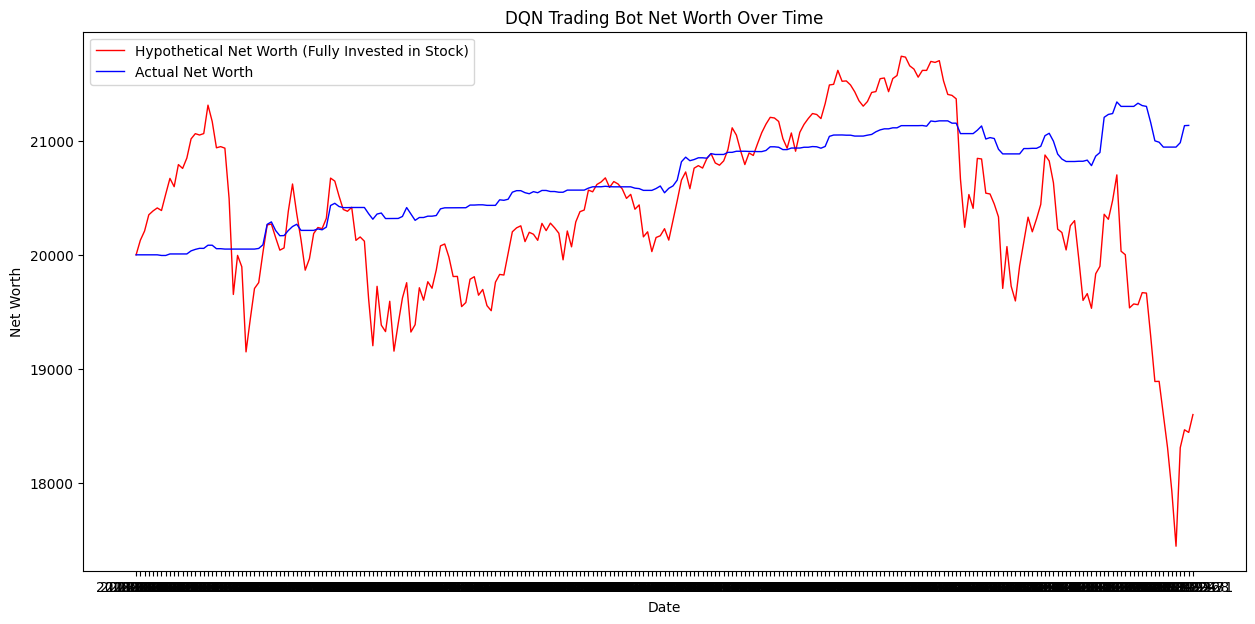

Episode 1/1 - Net Worth: 21135.737877071602
Average net worth over 1 episodes: 21135.737877071602


In [25]:
# Evaluation
def evaluate(env, agent, episodes=1):
    final_net_worths = []
    # total_rewards = 0
    for e in range(episodes):
        trades = []
        state = env.reset()
        state = state.flatten()
        networth = []
        for time in range(1,len(env.df)):
            action = agent.act(state)
            next_state, reward, done= env.step(action)
            trades.append((env.current_step, action))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
            if done:
                break
            networth.append(env.net_worth)
        plot_buy_sell(env,trades)
        plot_networth(env,networth)
        final_net_worths.append(env.net_worth)
        print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
        
    print(f"Average net worth over {episodes} episodes: {sum(final_net_worths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_dqn_temp.pth")
evaluate(env, agent)
# plt.savefig('saved_visuals/dqn_eval1.jpeg')